Za pomocą odpowiednich symulacji zbadać moc testów Shapiro-Wilka, Kołmogorowa-Smirnowa oraz testu χ2 w przypadku, gdy dane pochodzą z rozkładu t-Studenta lub innej klasy rozkładów symetrycznych.

Wyniki należy przedstawić na wykresach w zależności od:

- liczby danych,
- liczby stopni swobody generowanego rozkładu.

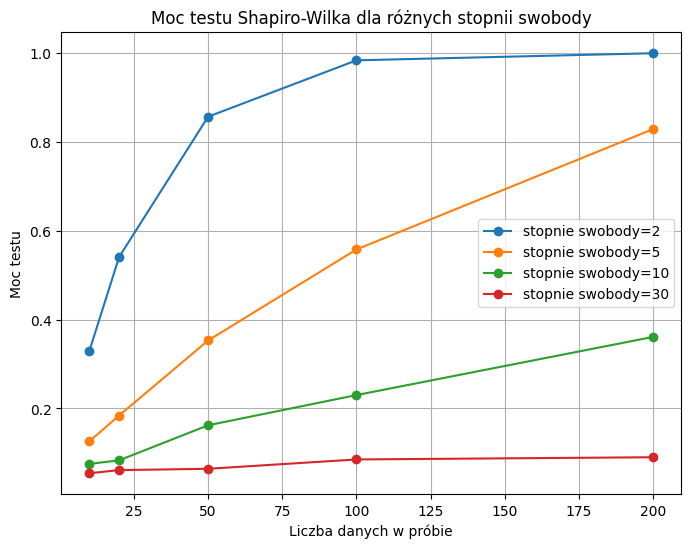

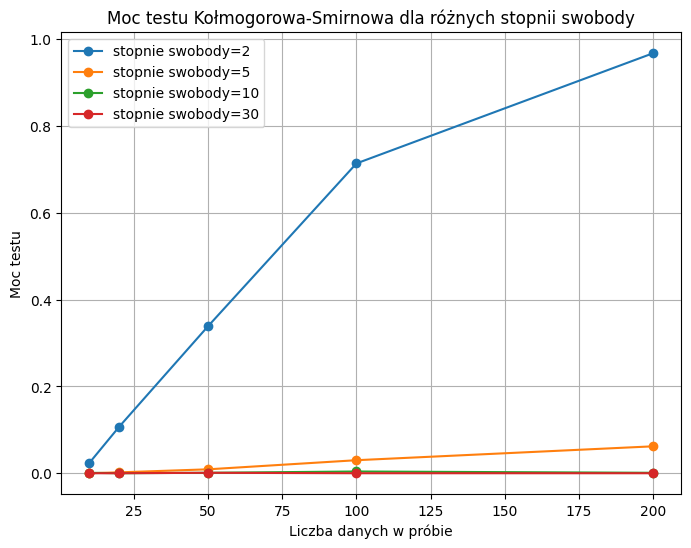

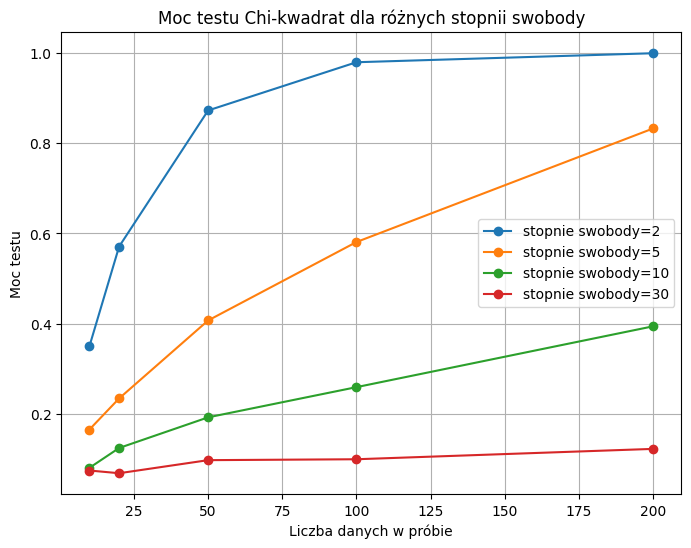

In [ ]:
import numpy as np
import scipy.stats as stats
import matplotlib.pyplot as plt

# funkcja pomocnicza do generowania testów. Jako parametr przyjmuje także inną funkcję,
# która zawiera logikę do testowania danego rozkładu oraz inne parametry doprecyzowujące testy
def test_power(test_func, df_range, sample_sizes, alpha=0.05, num_simulations=1000):
    power_results = np.zeros((len(df_range), len(sample_sizes)))
    
    for i, df in enumerate(df_range):
        for j, n in enumerate(sample_sizes):
            rejections = 0
            for _ in range(num_simulations):
                sample = np.random.standard_t(df, size=n)
                stat, p_value = test_func(sample)
                if p_value < alpha:
                    rejections += 1
            power_results[i, j] = rejections / num_simulations
    
    return power_results

# Parametry
df_range = [2, 5, 10, 30]  # Stopnie swobody
sample_sizes = [10, 20, 50, 100, 200]  # Liczba danych w próbie
num_simulations = 1000  # Liczba powtórzeń testu

# Testy
shapiro_results = test_power(stats.shapiro, df_range, sample_sizes, num_simulations=num_simulations)
ks_results = test_power(lambda x: stats.kstest(x, 'norm', args=(np.mean(x), np.std(x))), df_range, sample_sizes, num_simulations=num_simulations)
chi2_results = test_power(lambda x: stats.normaltest(x), df_range, sample_sizes, num_simulations=num_simulations)

def plot_results(results, test_name):
    plt.figure(figsize=(8, 6))
    for i, df in enumerate(df_range):
        plt.plot(sample_sizes, results[i, :], marker='o', label=f'stopnie swobody={df}')
    plt.xlabel('Liczba danych w próbie')
    plt.ylabel('Moc testu')
    plt.title(f'Moc testu {test_name} dla różnych stopnii swobody')
    plt.legend()
    plt.grid()
    plt.show()

plot_results(shapiro_results, "Shapiro-Wilka")
plot_results(ks_results, "Kołmogorowa-Smirnowa")
plot_results(chi2_results, "Chi-kwadrat")


Zbadać odsetek odrzuceń prawdziwej hipotezy głównej (błąd I rodzaju) w testach Kołmogorowa-Smirnowa oraz χ2 dla danych pochodzących z rozkładu χ2 o k stopniach swobody, porównując klasyczne testowanie z metodą PIT (Probability Integral Transform).

Analizę należy przeprowadzić w zależności od:
- liczby danych,
- liczby stopni swobody.

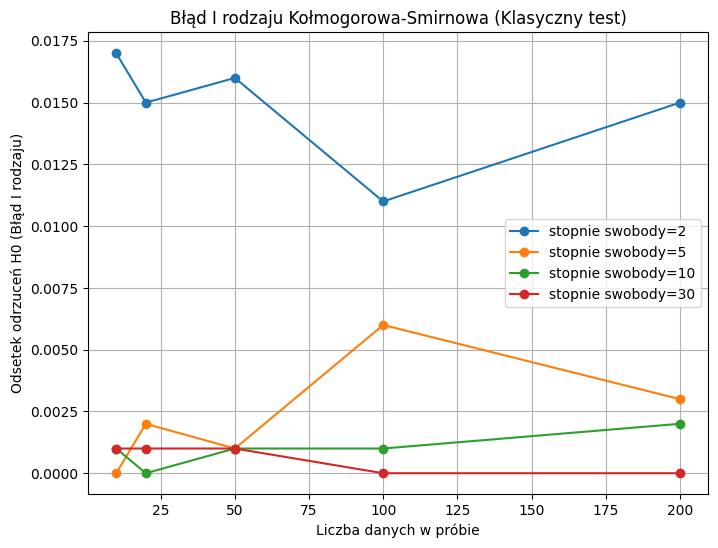

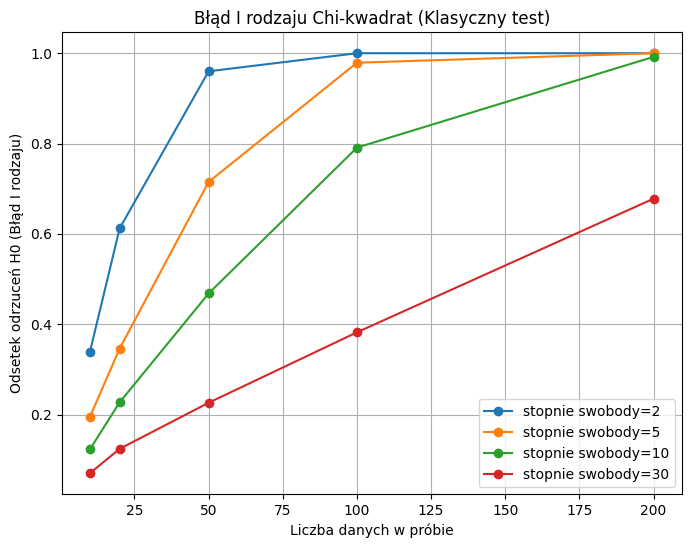

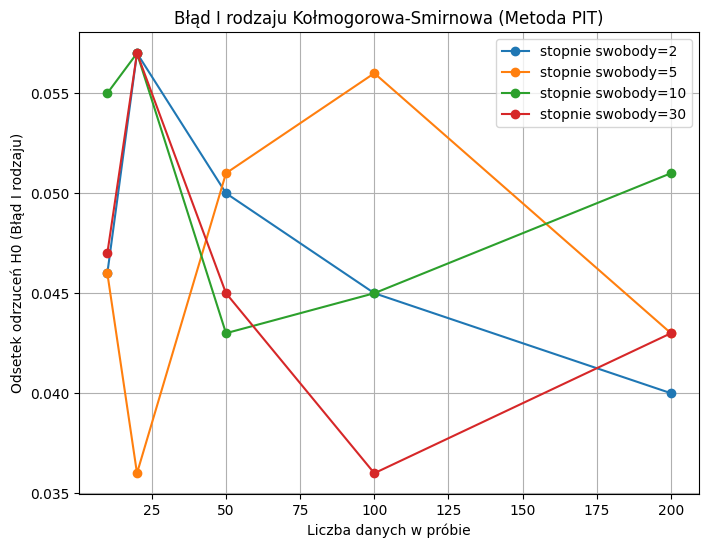

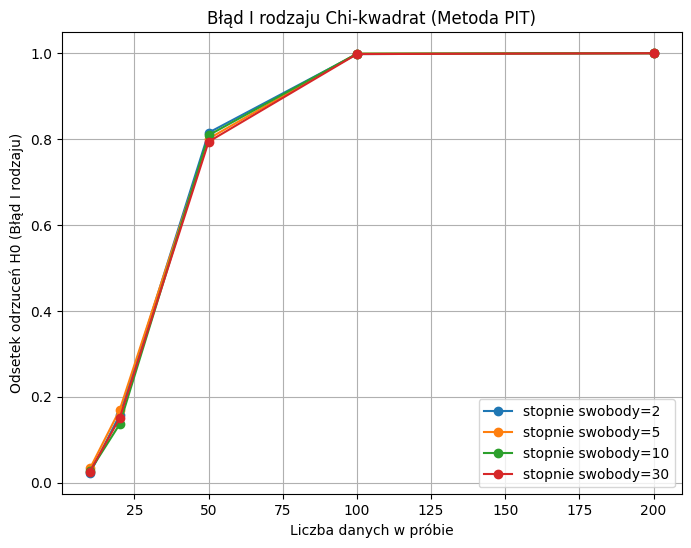

In [ ]:
import numpy as np
import scipy.stats as stats
import matplotlib.pyplot as plt

# Funkcja do badania błędu I rodzaju
def error_type_I(test_func, df_range, sample_sizes, alpha=0.05, num_simulations=1000, pit_transform=False):
    error_rates = np.zeros((len(df_range), len(sample_sizes)))
    
	# Iterujemy uwzględniajać ustawienia testu
    for i, df in enumerate(df_range):
        for j, n in enumerate(sample_sizes):
            rejections = 0
            for _ in range(num_simulations):
                sample = np.random.chisquare(df, size=n)
                
                if pit_transform:
                    sample = stats.chi2.cdf(sample, df)  # transformacja PIT
                
                stat, p_value = test_func(sample)
                if p_value < alpha:
                    rejections += 1
            error_rates[i, j] = rejections / num_simulations
    
    return error_rates

# Parametry
df_range = [2, 5, 10, 30]  # Stopnie swobody
sample_sizes = [10, 20, 50, 100, 200]  # Wielkość próby
num_simulations = 1000  # Liczba symulacji

# Klasyczne testy
ks_classic = error_type_I(lambda x: stats.kstest(x, 'chi2', args=(np.mean(x),)), df_range, sample_sizes, num_simulations=num_simulations)
chi2_classic = error_type_I(lambda x: stats.normaltest(x), df_range, sample_sizes, num_simulations=num_simulations)

# Testy z metodą PIT
ks_pit = error_type_I(lambda x: stats.kstest(x, 'uniform'), df_range, sample_sizes, num_simulations=num_simulations, pit_transform=True)
chi2_pit = error_type_I(lambda x: stats.normaltest(x), df_range, sample_sizes, num_simulations=num_simulations, pit_transform=True)

def plot_error_rates(results, test_name, method):
    plt.figure(figsize=(8, 6))
    for i, df in enumerate(df_range):
        plt.plot(sample_sizes, results[i, :], marker='o', label=f'stopnie swobody={df}')
    plt.xlabel('Liczba danych w próbie')
    plt.ylabel('Odsetek odrzuceń H0 (Błąd I rodzaju)')
    plt.title(f'Błąd I rodzaju {test_name} ({method})')
    plt.legend()
    plt.grid()
    plt.show()

plot_error_rates(ks_classic, "Kołmogorowa-Smirnowa", "Klasyczny test")
plot_error_rates(chi2_classic, "Chi-kwadrat", "Klasyczny test")
plot_error_rates(ks_pit, "Kołmogorowa-Smirnowa", "Metoda PIT")
plot_error_rates(chi2_pit, "Chi-kwadrat", "Metoda PIT")


Zbadać moc testu Kołmogorowa-Smirnowa dla próbek pochodzących z rozkładów X^2 o różnych stopniach swobody, przesuwając dane tak, by miały tę samą wartość oczekiwaną. Wyniki należy zilustrować na wykresach, uwzględniając:

- liczebność próbek (różne dla każdej próbki),
- liczbę stopni swobody.

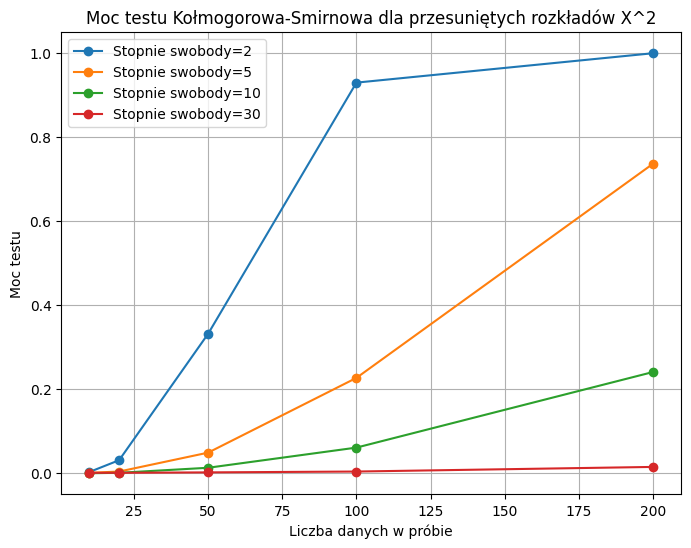

In [ ]:
import numpy as np
import scipy.stats as stats
import matplotlib.pyplot as plt

# Funkcja obliczająca moc testu KS dla rozkładu X^2 z normalizacją wartości oczekiwanej
def ks_test_power_adjusted(df_range, sample_sizes, alpha=0.05, num_simulations=1000):
    power_results = np.zeros((len(df_range), len(sample_sizes)))

    for i, df in enumerate(df_range):
        expected_value = df  # Wartość oczekiwana dla X^2(df) = df
        for j, n in enumerate(sample_sizes):
            rejections = 0
            for _ in range(num_simulations):
                sample = np.random.chisquare(df, size=n)
                adjusted_sample = sample - np.mean(sample) + expected_value  # Przesuwam średnią
                stat, p_value = stats.kstest(adjusted_sample, 'norm', args=(expected_value, np.std(adjusted_sample)))
                if p_value < alpha:
                    rejections += 1
            power_results[i, j] = rejections / num_simulations

    return power_results

# Parametry
df_range = [2, 5, 10, 30]  # Stopnie swobody rozkładu X^2
sample_sizes = [10, 20, 50, 100, 200]  # Liczności próbek
num_simulations = 1000  # Liczba powtórzeń testu

# Obliczam moce testów
ks_power_results = ks_test_power_adjusted(df_range, sample_sizes, num_simulations=num_simulations)

def plot_power_results(results, test_name):
    plt.figure(figsize=(8, 6))
    for i, df in enumerate(df_range):
        plt.plot(sample_sizes, results[i, :], marker='o', label=f'Stopnie swobody={df}')
    plt.xlabel('Liczba danych w próbie')
    plt.ylabel('Moc testu')
    plt.title(f'Moc testu {test_name} dla przesuniętych rozkładów X^2')
    plt.legend()
    plt.grid()
    plt.show()

plot_power_results(ks_power_results, "Kołmogorowa-Smirnowa")


Przeanalizować wpływ liczby klas (przedziałów) na odsetek odrzuceń prawdziwej hipotezy głównej w teście X^2 przy weryfikacji zgodności z rozkładem X^2 o różnych stopniach swobody, prezentując wyniki w zależności od:

- liczby danych,
- liczby klas,
- liczby stopni swobody generowanego rozkładu.

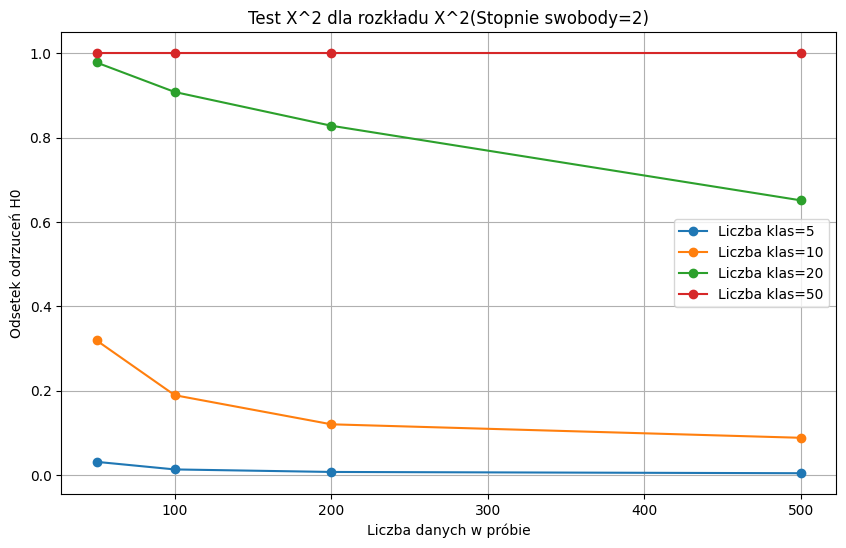

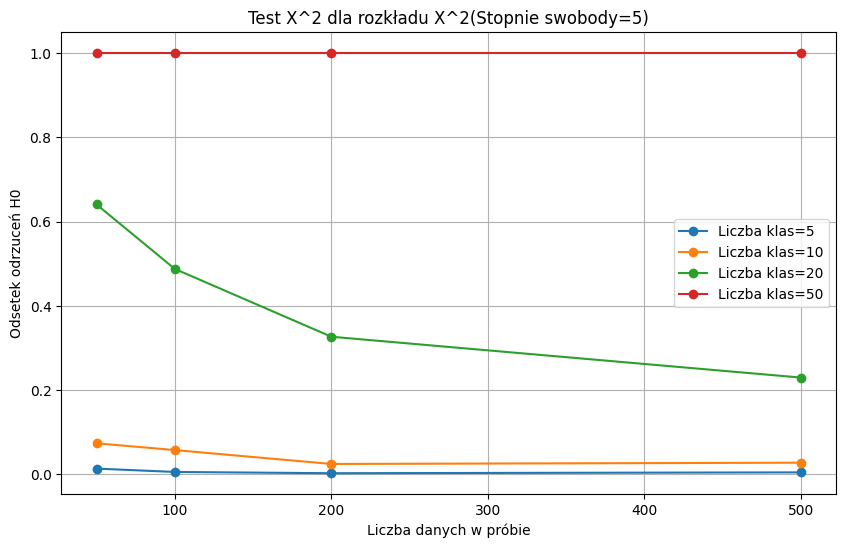

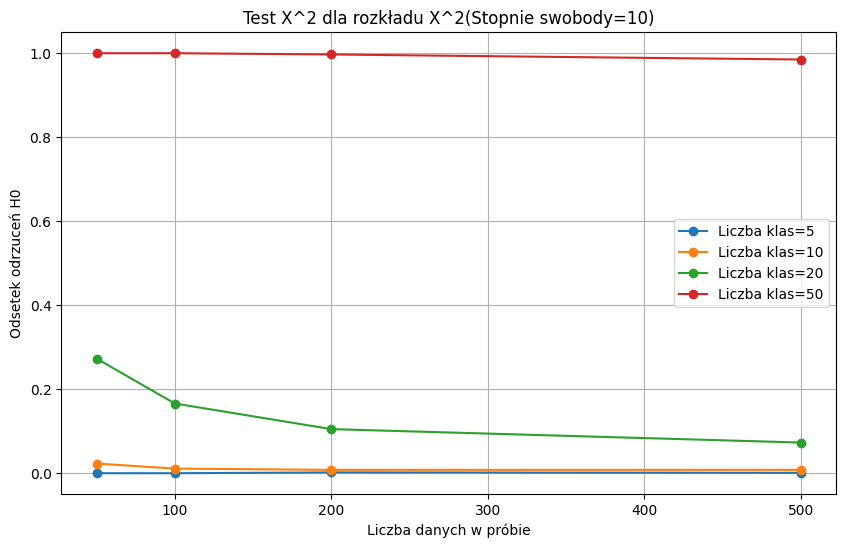

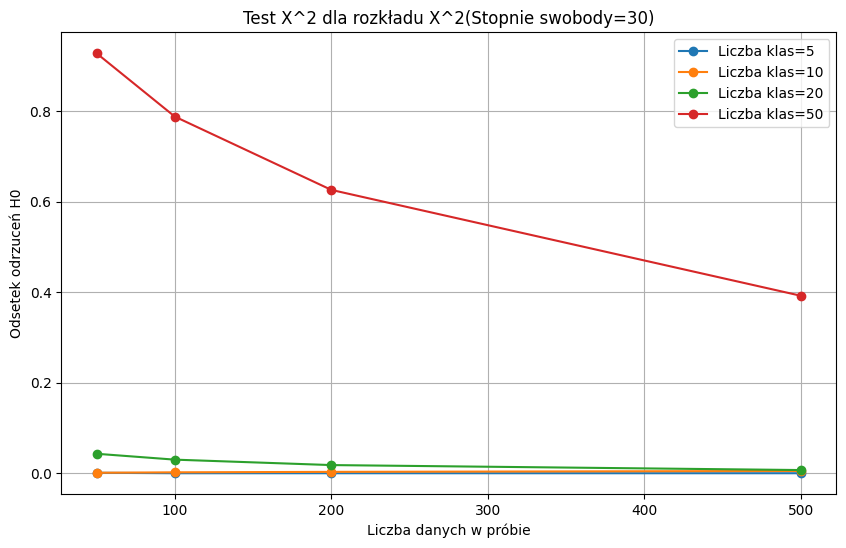

In [6]:
import numpy as np
import scipy.stats as stats
import matplotlib.pyplot as plt

def chi2_test_power(df_range, sample_sizes, bin_counts, alpha=0.05, num_simulations=1000):
    power_results = np.zeros((len(df_range), len(sample_sizes), len(bin_counts)))
    
    for i, df in enumerate(df_range):
        for j, n in enumerate(sample_sizes):
            for k, bins in enumerate(bin_counts):
                rejections = 0
                for _ in range(num_simulations):
                    sample = np.random.chisquare(df, size=n)
                    hist, bin_edges = np.histogram(sample, bins=bins, density=True)
                    expected_freq = np.diff(bin_edges) * stats.chi2.pdf((bin_edges[:-1] + bin_edges[1:]) / 2, df)
                    expected_freq *= np.sum(hist * n) / np.sum(expected_freq)  # Skalowanie do liczby próbek
                    
                    if np.any(expected_freq == 0):
                        continue  # Pomijam przypadki z zerową oczekiwaną licznością
                    
                    stat, p_value = stats.chisquare(hist * n, expected_freq)
                    if p_value < alpha:
                        rejections += 1
                power_results[i, j, k] = rejections / num_simulations
    
    return power_results

# Parametry
df_range = [2, 5, 10, 30]  # Stopnie swobody rozkładu X^2
sample_sizes = [50, 100, 200, 500]  # Liczności próbek
bin_counts = [5, 10, 20, 50]  # Liczba klas
num_simulations = 1000  # Liczba powtórzeń testu

# Obliczam moce testów
chi2_power_results = chi2_test_power(df_range, sample_sizes, bin_counts, num_simulations=num_simulations)

def plot_power_results(results, df_range, sample_sizes, bin_counts):
    for i, df in enumerate(df_range):
        plt.figure(figsize=(10, 6))
        for k, bins in enumerate(bin_counts):
            plt.plot(sample_sizes, results[i, :, k], marker='o', label=f'Liczba klas={bins}')
        plt.xlabel('Liczba danych w próbie')
        plt.ylabel('Odsetek odrzuceń H0')
        plt.title(f'Test X^2 dla rozkładu X^2(Stopnie swobody={df})')
        plt.legend()
        plt.grid()
        plt.show()

plot_power_results(chi2_power_results, df_range, sample_sizes, bin_counts)


Odsetek odrzuceń H0 dla liczby klas 50 i 2 lub 5 stopnii swobody jest bliski 1:
- ponieważ większa liczba klas zwiększa czułość testu
- mała liczba stopni swobody oznacza większą skośność